In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [41]:
def data_load():
    df = pd.read_excel('/Users/nkt1lyn/coef_opr_actions.xlsx')
    return df

In [42]:
def data_shape(df, date1, date2):
    df = df.loc[(df['Time'] >= date1) & (df['Time'] <= date2)]
    return df

In [43]:
def shift_model(df, l):
    l = -l
    df['Период'] = np.roll(df['Период'], l)
    # df = pd.concat([df.iloc[l:], df.iloc[:l]], ignore_index=True)
    if l > 0:
        df.loc[:l-1, 'Период'] = 1
    elif l == 0:
      return df
    else:
      df.iloc[l:, df.columns.get_loc('Период')] = 13
    return df

In [44]:
def day_cat(df):
    df['Категория дня'] = np.where((df['Var1'] >= mean - std) & (df['Var1'] <= mean + std), 'White', 'Black').astype(str)
    return df

In [45]:
def model_with_shift(l):
    df = data_load()
    df = data_shape(df, '2019-12-21', '2023-03-04')
    df = day_cat(df)
    df['Период'] = (df['Time'].sub(df['Time'].min()) // pd.Timedelta('90 days')).add(1)
    df = shift_model(df, l)
    return df

In [46]:
def calculate_levels(group):
   Std1 = (group['Var1'] >= mean - std) & (group['Var1'] <= mean + std)

   W = Std1.sum()
   B = len(group) - W

   BL1 = 100 * W / len(group)
   BL2 = 100 * B / len(group)

   return pd.Series({'Период': group['Период'].iloc[0], 'BW': [BL1, BL2]})

In [47]:
def BW_calc(df):
    result = df.groupby('Период').apply(calculate_levels).reset_index(drop=True)
    W = result['BW'].apply(lambda x: x[0]).sum()/len(result)
    B = result['BW'].apply(lambda x: x[1]).sum()/len(result)
    return [W, B]

In [48]:
df = data_load()
df = data_shape(df, '2019-12-21', '2023-03-04')

In [49]:
mean = df['Var1'].mean()
std = df['Var1'].std()
Std1 = (df['Var1'] >= mean - std) & (df['Var1'] <= mean + std)

W = Std1.sum()
B = len(df) - W

BL1 = 100 * W / len(df)
BL2 = 100 * B / len(df)

BL = [BL1, BL2]
BL

[71.02564102564102, 28.974358974358974]

In [50]:
def fit_error_calc(BW, BL = BL):
    fit_error = np.linalg.norm([BW[0]-BL[0], BW[1]-BL[1]])
    return fit_error

In [51]:
def FE_table(list):
    model = []
    fit_error = []
    
    for l in list:
        model.append('i = ' + str(l))
        fit_error.append(fit_error_calc(BW_calc(model_with_shift(l))))

    FE = pd.DataFrame({
        'Model': model,
        'Fit-error': fit_error
        })
    return FE

1. Нужно построить график зависимости ошибки соответствия модели данным (fit-error) от ее параметра l для l, которое меняется в пределах от -40 до +40 (всего 81 значение, включая 0)


In [52]:
l_values = [l for l in range(-40, 40+1)]
fit_errors = FE_table(l_values)['Fit-error'].values

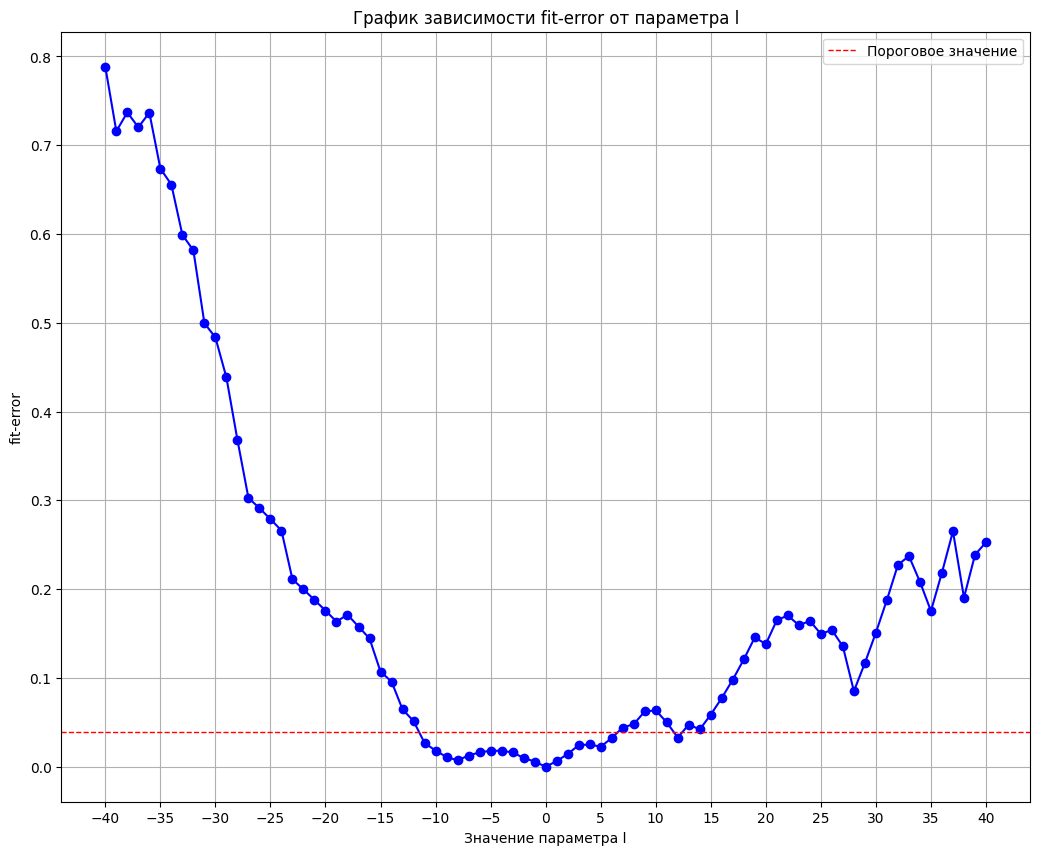

In [53]:
threshold = 0.05 * (max(fit_errors) - min(fit_errors))

plt.figure(figsize=(12.5, 10))
plt.plot(l_values, fit_errors, marker='o', linestyle='-', color='b')
plt.axhline(y=threshold, color='r', linestyle='--', linewidth=1, label='Пороговое значение')
plt.xticks(np.arange(min(l_values), max(l_values)+1, 5))
plt.title('График зависимости fit-error от параметра l')
plt.xlabel('Значение параметра l')
plt.ylabel('fit-error')
plt.grid(True)
plt.legend()
plt.show()

2. заполнить таблицу со значениями ошибки соответствия данным с указанием значений параметра l. 


In [54]:
FE_table(l_values)

,Model,Fit-error
0,i = -40,0.788464
1,i = -39,0.715813
2,i = -38,0.737005
3,i = -37,0.720245
4,i = -36,0.736749
...,...,...
76,i = 36,0.218722
77,i = 37,0.265109
78,i = 38,0.190462
79,i = 39,0.238604


3. Диаграммы пока приводить не нужно. Но нужно иметь возможность построить диаграмму для любого выбранного l из заданного диапазона [-40, 40].